# Tornado Magnitude Prediction

The motivation of the project is to predict the magnitude of a tornado from historical data collected of various tornadoes in the USA from 1950 to 2019 by the National Weather Service.

This is a regression type of problem, and the following regressors are built: lasso regression, multilayer perceptron, xgboost regreesor, and by combining the models with stacking regressor. As a single number evaluation metric $R^2$ is used.

The most optimal model for this application is the stacking regressor which has the highest $R^2=0.595533$.

Technologies used in this project are: scikit-learn, XGBoost, mlxtend, ensemble learning, Jupyter Notebook.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from time import time

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [4]:
from sklearn.metrics import r2_score, mean_squared_error

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Data Analysis

The data set can be downloaded from the following link: https://www.spc.noaa.gov/wcm/#data.

In [6]:
tornado = pd.read_csv('data/1950-2019_all_tornadoes.csv')
tornado.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
om,1,1,1,2,3,4,5,6,7,8
yr,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950
mo,1,1,1,1,1,1,1,1,1,2
dy,3,3,3,3,3,13,25,25,26,11
date,1950-01-03,1950-01-03,1950-01-03,1950-01-03,1950-01-03,1950-01-13,1950-01-25,1950-01-25,1950-01-26,1950-02-11
time,11:00:00,11:00:00,11:10:00,11:55:00,16:00:00,05:25:00,19:30:00,21:00:00,18:00:00,13:10:00
tz,3,3,3,3,3,3,3,3,3,3
st,MO,MO,IL,IL,OH,AR,MO,IL,TX,TX
stf,29,29,17,17,39,5,29,17,48,48
stn,1,1,1,2,1,1,2,3,1,2


- `date` could be dropped, because the same information is contained in `yr`, `mo` and `dy`, and it is already processed.
- The seconds from `time` can be dropped because they all seem to be zero, which isn't a surprise. Is it really that important at what second did the tornado formed, and on top off that, is it even possible to precisley measure that?
- Postal and FIPS codes are irrelevant, because that information is contained in the start and ending longitude and latitude.
- `mag` is the target.

In [7]:
tornado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66388 entries, 0 to 66387
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   om      66388 non-null  int64  
 1   yr      66388 non-null  int64  
 2   mo      66388 non-null  int64  
 3   dy      66388 non-null  int64  
 4   date    66388 non-null  object 
 5   time    66388 non-null  object 
 6   tz      66388 non-null  int64  
 7   st      66388 non-null  object 
 8   stf     66388 non-null  int64  
 9   stn     66388 non-null  int64  
 10  mag     66388 non-null  int64  
 11  inj     66388 non-null  int64  
 12  fat     66388 non-null  int64  
 13  loss    66388 non-null  float64
 14  closs   66388 non-null  float64
 15  slat    66388 non-null  float64
 16  slon    66388 non-null  float64
 17  elat    66388 non-null  float64
 18  elon    66388 non-null  float64
 19  len     66388 non-null  float64
 20  wid     66388 non-null  int64  
 21  ns      66388 non-null  int64  
 22

In [8]:
num_feats_n = len(tornado.drop('mag', axis=1).select_dtypes(np.number).columns)
cat_feats_n = (tornado.shape[1] - 1) - num_feats_n
print(num_feats_n, cat_feats_n)

25 3


| Data set info: |  |
| :--- | :--- |
| Number of features | 28 |
| Number of examples | 66388 |
| Number of numerical features | 25 |
| Number of categorical features | 3 |
| Memory Usage | 14.7+ MB |
| Target | `mag` |
| ML Problem Type | Regression |

In [9]:
tornado.isnull().sum().sum()

0

There aren't any missing data.

In [10]:
tornado.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
om,66388.0,86411.769341,1.991383e+05,1.00,267.0000,555.00000,993.00,6.185410e+05
yr,66388.0,1990.307616,1.887569e+01,1950.00,1975.0000,1993.00000,2006.00,2.019000e+03
mo,66388.0,5.951106,2.418750e+00,1.00,4.0000,6.00000,7.00,1.200000e+01
dy,66388.0,15.931238,8.770038e+00,1.00,8.0000,16.00000,24.00,3.100000e+01
tz,66388.0,3.000994,7.363260e-02,0.00,3.0000,3.00000,3.00,9.000000e+00
stf,66388.0,29.286106,1.499736e+01,1.00,18.0000,28.00000,45.00,7.800000e+01
stn,66388.0,24.260017,3.206421e+01,0.00,2.0000,13.00000,33.00,2.320000e+02
mag,66388.0,0.760152,1.131374e+00,-9.00,0.0000,1.00000,1.00,5.000000e+00
inj,66388.0,1.640417,2.048568e+01,0.00,0.0000,0.00000,0.00,1.740000e+03
fat,66388.0,0.105185,1.626544e+00,0.00,0.0000,0.00000,0.00,1.580000e+02


In [11]:
tornado.describe(include=np.object)

,date,time,st
count,66388,66388,66388
unique,11965,1437,53
top,2011-04-27,16:00:00,TX
freq,235,985,9031


In [12]:
def uniqueValues(df):
    for column in df:
        unique_values = df[column].unique()
        print(f'Unique values of feature {column} are: {unique_values}')

uniqueValues(tornado.select_dtypes('object'))

Unique values of feature date are: ['1950-01-03' '1950-01-13' '1950-01-25' ... '2019-12-27' '2019-12-28'
 '2019-12-29']
Unique values of feature time are: ['11:00:00' '11:10:00' '11:55:00' ... '03:54:00' '02:57:00' '05:21:00']
Unique values of feature st are: ['MO' 'IL' 'OH' 'AR' 'TX' 'MS' 'LA' 'TN' 'OK' 'FL' 'AL' 'SC' 'KS' 'IA'
 'SD' 'NE' 'WY' 'NC' 'GA' 'ND' 'MN' 'WI' 'IN' 'PA' 'NM' 'CT' 'CO' 'WV'
 'MD' 'KY' 'CA' 'VA' 'NJ' 'MI' 'MA' 'NH' 'OR' 'NY' 'MT' 'AZ' 'UT' 'ME'
 'VT' 'ID' 'WA' 'DE' 'HI' 'PR' 'AK' 'NV' 'RI' 'DC' 'VI']


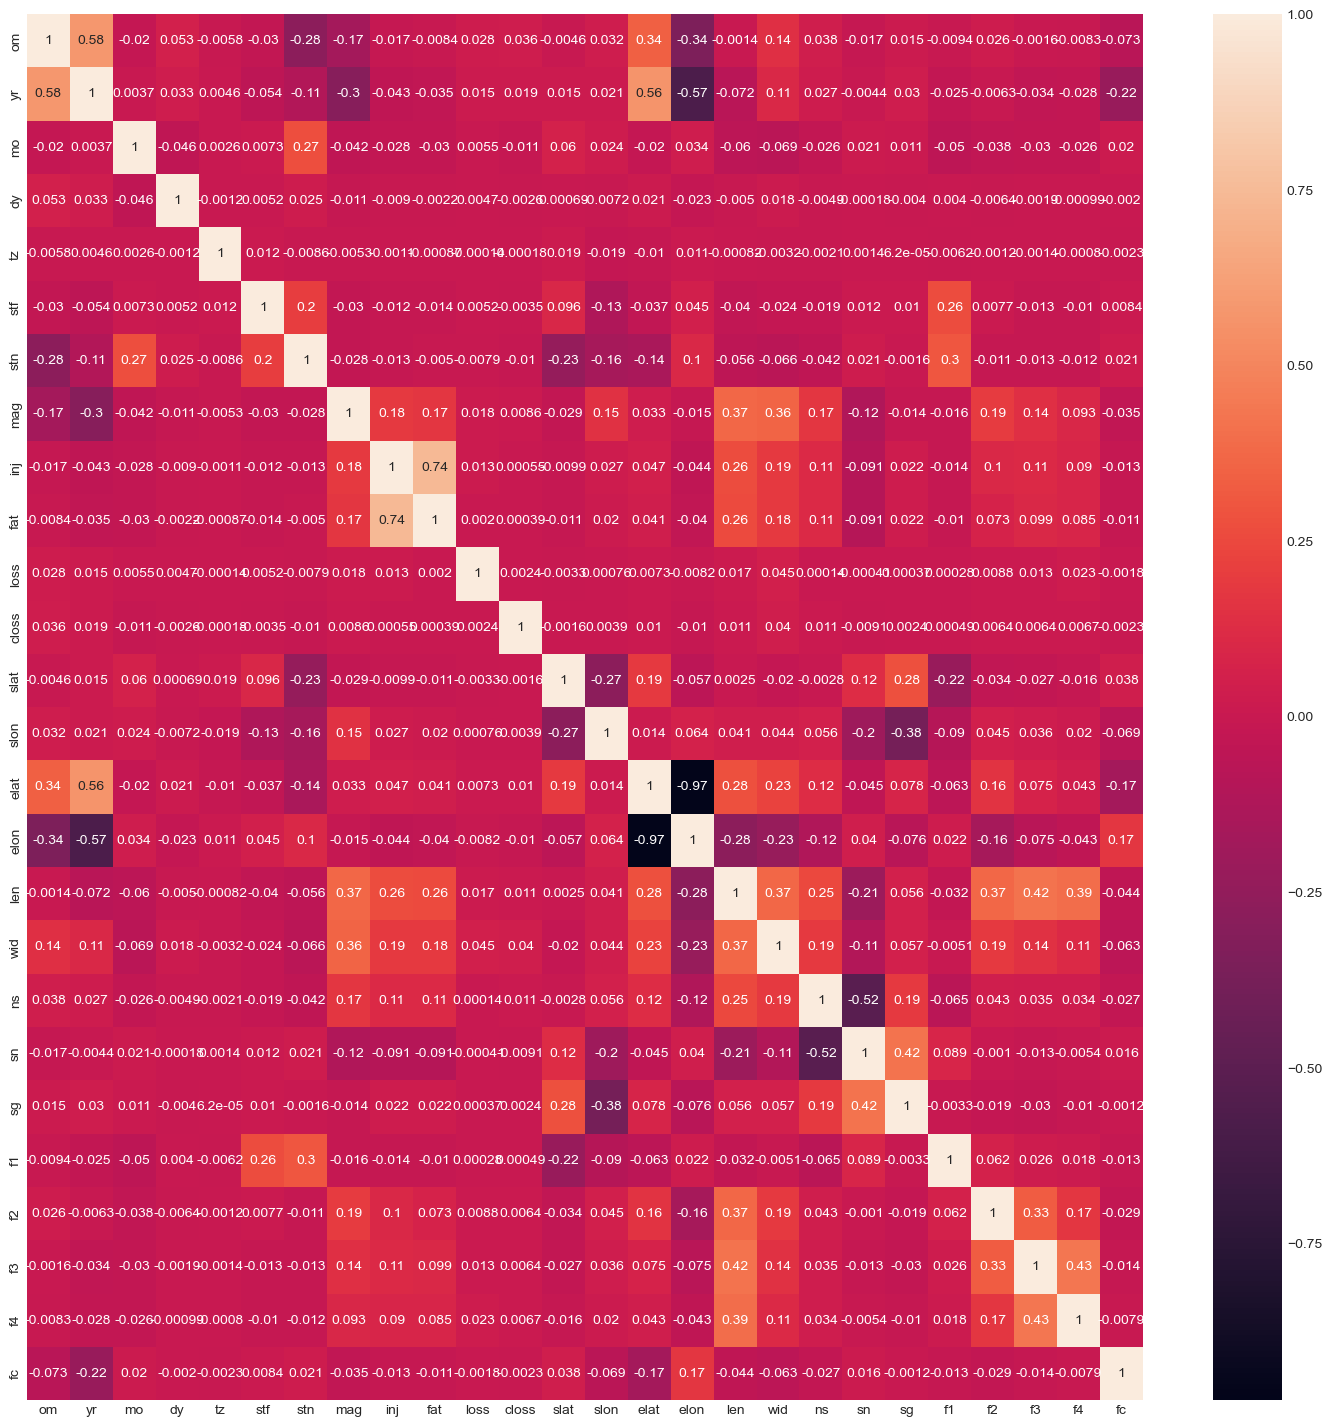

In [13]:
plt.figure(figsize=(18,18))
corr_matrix = tornado.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

The features are weakly correlated which should be benefitial to fit linear models. However, the features are also weakly correlated with the target, meaning there isn't a linear relationship. This doesn't necesseraly mean that there isn't a non-linear relationship.

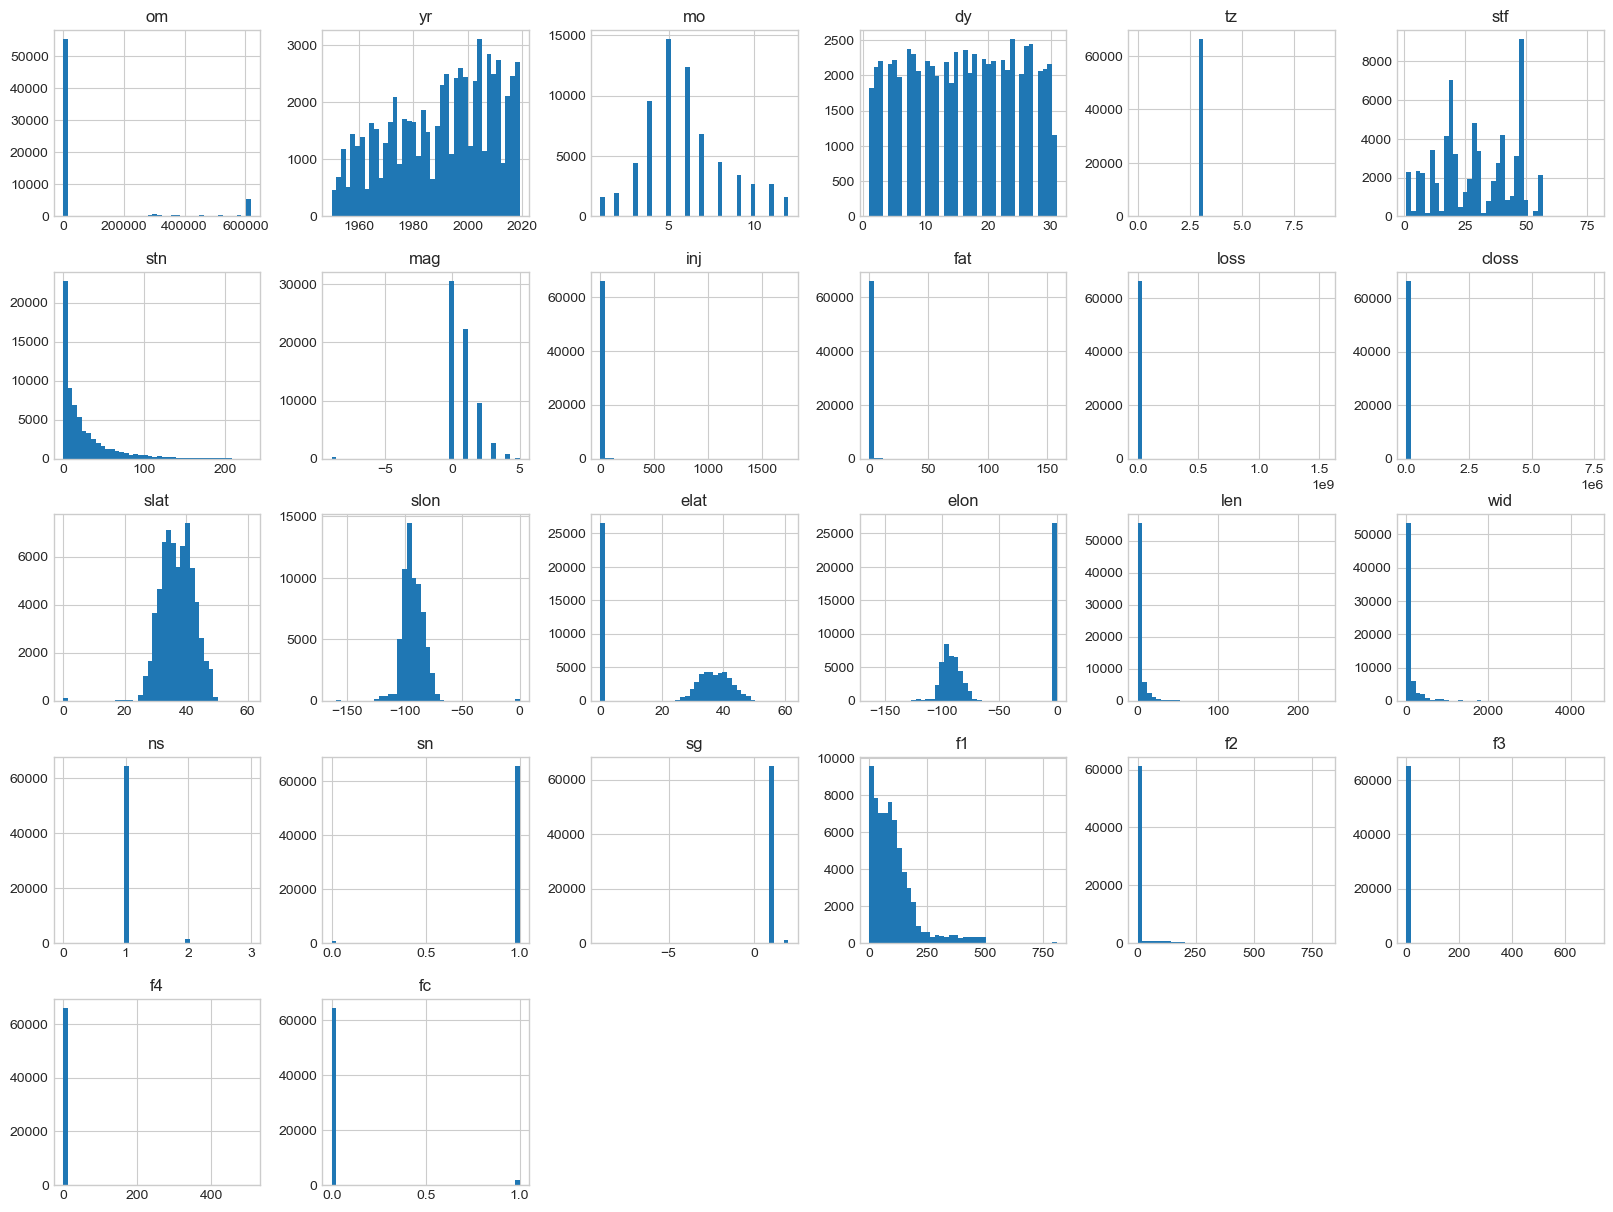

In [14]:
tornado.hist(figsize=(20,15), layout=(5,6), bins=40)
plt.show()

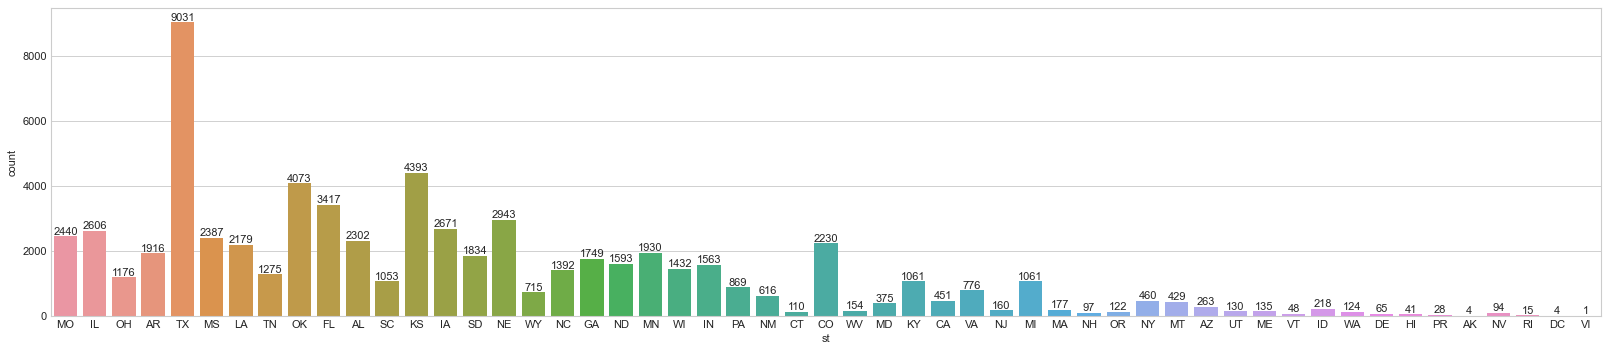

In [15]:
fig = plt.figure(figsize=(25, 5), dpi=80)
ax = sns.countplot(x='st', data=tornado)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(f'{p.get_height()}', (x.mean(), y), ha='center', va='bottom')
plt.show()

## Data Preprocessing

It turned out that there are irrelevant features which should be dropped. Also, the hour and minute at which the tornado occured should be reformated in a `datetime` format.

In [16]:
def drop_and_reformat(df):
    df = df.copy()
    
    df['time'] =  pd.to_datetime(df['time'])
    df['hour'] = df['time'].apply(lambda x: x.hour)
    df['minute'] = df['time'].apply(lambda x: x.minute)
    
    # Drop irrelevant features
    df = df.drop(['om', 'st', 'stf', 'stn', 'date', 'time', 'f1', 'f2', 'f3', 'f4', 'fc'], axis=1)
    
    return df

In [17]:
X = tornado.drop('mag', axis=1)
y = tornado['mag']

In [18]:
X = drop_and_reformat(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [20]:
X_train.shape[0], X_test.shape[0]

(56429, 9959)

## Models

In this project the problem of predicting the magnitude of tornado will be solved with a stacking learning algorithm. Stacking is a type of ensemble learning where the architecture of the model is such that there are base models which spit out predictions, and the outputs of the base models are fed to a meta model with the goal to improve the overall performance of the weaker base models. The choice of base learning algorithms should be from a wide range of algortihms that have a different approach in predicting, like linear models, support vector machines, CARTs (Classification And Regression Trees), artificial neural networks (ANNs) etc. The performance of the stacking model is usually close to the most optimal base model and sometimes it can outperform each base model. However, this is not a given. If one of the base models outperforms the stacking model, than the base model should be used.

Thus, for this project the following base algorithms will be trained:
- Lasso Regression (linear model);
- Multilayer Perceptron (artificial neural network model);
- XGBoost Regressor (CART model);

and they will be fed to the meta model Lasso Regression.

### Lasso Regression

In [21]:
lasso_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV())
])

### MLP

In [22]:
mlp_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('mlp', MLPRegressor())
])

### XGBoost

In [23]:
xgb = XGBRegressor()

### StackingCVRegressor

In [24]:
stack = StackingCVRegressor(regressors=(lasso_pipeline, mlp_pipeline, XGBRegressor()),
                            meta_regressor=LassoCV(),
                            random_state=12345)

### Training

In [25]:
for reg in [lasso_pipeline, mlp_pipeline, xgb, stack]:
    reg.fit(X_train, y_train)

In [26]:
print('5-fold cross validation scores:\n')

for reg, label in zip([lasso_pipeline, mlp_pipeline, xgb, stack],
                      ['Lasso', 'MLP', 'XGBoost', 'StackingCVRegressor']):
    t0 = time()
    scores = cross_val_score(estimator=reg, X=X_train, y=y_train, scoring='r2', cv=5, n_jobs=-1)
    elapsed_time = time() - t0
    elapsed_minutes = elapsed_time / 60
    print(f"R^2 Score: {scores.mean()} (+/- {scores.std()}) \t Evaluation in {elapsed_minutes:.2f} minutes \t [{label}]")

5-fold cross validation scores:

R^2 Score: 0.3197465490943769 (+/- 0.005242604744945938) 	 Evaluation in 0.13 minutes 	 [Lasso]
R^2 Score: 0.4642857233499864 (+/- 0.009845959518931881) 	 Evaluation in 0.94 minutes 	 [MLP]
R^2 Score: 0.6124476674963755 (+/- 0.009203435826851056) 	 Evaluation in 0.15 minutes 	 [XGBoost]
R^2 Score: 0.6124824585043982 (+/- 0.009349271158015133) 	 Evaluation in 4.81 minutes 	 [StackingCVRegressor]


## Evaluation Metrics

In [27]:
RMSEs = [] # If True returns MSE value, if False returns RMSE value.
R2_scores = []

In [28]:
for reg in [lasso_pipeline, mlp_pipeline, xgb, stack]:
    RMSEs.append(mean_squared_error(y_test, reg.predict(X_test), squared=False))
    R2_scores.append(r2_score(y_test, reg.predict(X_test)))

In [29]:
scoring_summary = pd.DataFrame({
    'Model': ['Lasso', 'MLP', 'XGBoost', 'StackingCVRegressor'],
    'R2 Score': R2_scores,
    'RMSE': RMSEs,
})

scoring_summary = scoring_summary.sort_values('R2 Score', ascending=False)

In [30]:
scoring_summary

,Model,R2 Score,RMSE
3,StackingCVRegressor,0.595533,0.692750
2,XGBoost,0.594041,0.694027
1,MLP,0.451555,0.806680
0,Lasso,0.318004,0.899551
